In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import operator

In [2]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  

### 整理数据

#### 整理test数据

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [5]:
#补充缺失数据
# 特征Open存在数据缺失
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())

In [6]:
# 把date拆成year，month和day，重新设置DayOfWeek原因是DayOfWeek比dayofweek多1
test['Date']=pd.to_datetime(test['Date'])

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

In [7]:
#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [8]:
# 如果open特征为0可以直接提交预测为0
test["Open"].value_counts()

1    35104
0     5984
Name: Open, dtype: int64

#### 整理store数据

In [9]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [10]:
#处理缺失数据
#CompetitionDistance中缺失三条,缺失的数据里同时缺失CompetitionOpenSinceMonth和CompetitionOpenSinceYear，我将其认为在合理距离范围内无竞争对手。
print(store.query('CompetitionDistance=="NaN"')[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']])
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879

     Store  CompetitionDistance  CompetitionOpenSinceMonth  \
290    291                  nan                        nan   
621    622                  nan                        nan   
878    879                  nan                        nan   

     CompetitionOpenSinceYear  
290                       nan  
621                       nan  
878                       nan  


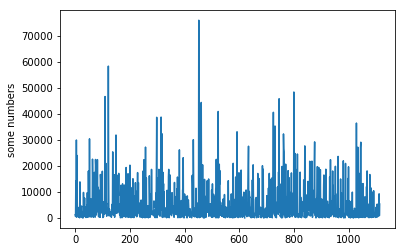

In [11]:
#查看CompetitionDistance的情况
store['CompetitionDistance'].describe()
#根据情况将291，622，879的CompetitionDistance距离改为99999
plt.plot(store['CompetitionDistance'])
plt.ylabel('some numbers')
plt.show()


In [12]:
#根据情况将291，622，879的CompetitionDistance距离改为99999并转化为int型，将其CompetitionOpenSinceYear特征改为一个未来值
store['CompetitionDistance']=store['CompetitionDistance'].fillna(99999)
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
# store.query('Store in (291,622,879)')['CompetitionOpenSinceYear']=2030
store.loc[(store['Store']==291)|(store['Store']==622)|(store['Store']==879),'CompetitionOpenSinceYear']=2030

In [13]:
# CompetitionOpenSinceMonth和CompetitionOpenSinceYear的缺失值
# 判断是否缺失的商店是同一个，输出同时为NaN的商店个数
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))

351


In [14]:
# 1115-354=761所以均为同时为Nan，那就设置为一个较早的时间，认为是早已经开业的商店,并设置为int型
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(2010)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(0)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

In [15]:
# Promo2SinceWeek,Promo2SinceYear,PromoInterval的缺失值
# 确认他们缺失的是否是相同的store
nan = np.nan
print(len(store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')))

544


In [16]:
# 1115-544=571,571符合这三个特征的缺失数，得出结论就是这三个特征是同时缺失的，看看此时的Promo2的值是多少
store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')['Promo2'].value_counts()

0    544
Name: Promo2, dtype: int64

In [17]:
# 查看0的总总数量和Promo2SinceWeek,Promo2SinceYear,PromoInterval缺失值保持一致
store['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [18]:
# 将Promo2SinceYear设置为一个未来的时间，Promo2SinceWeek设置为1
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(2030)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

In [19]:
#处理PromoInterval,
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'0,3,6,9','Feb,May,Aug,Nov':'1,4,7,10','Mar,Jun,Sept,Dec':'2,5,8,11'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0,2030,"0,0,0,0"
1,2,a,a,570,11,2007,1,13,2010,"0,3,6,9"
2,3,a,a,14130,12,2006,1,14,2011,"0,3,6,9"
3,4,c,c,620,9,2009,0,0,2030,"0,0,0,0"
4,5,a,a,29910,4,2015,0,0,2030,"0,0,0,0"


In [20]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
dtypes: int32(5), int64(2), object(3)
memory usage: 65.4+ KB


In [21]:
print(store['PromoInterval'].value_counts())

0,0,0,0     544
0,3,6,9     335
1,4,7,10    130
2,5,8,11    106
Name: PromoInterval, dtype: int64


In [22]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1,dtype='int32')
store['PromoInterval2']=pd.Series(PromoInterval2,dtype='int32')
store['PromoInterval3']=pd.Series(PromoInterval3,dtype='int32')
store['PromoInterval4']=pd.Series(PromoInterval4,dtype='int32')
store.drop('PromoInterval',axis=1, inplace=True)

In [23]:
#处理两个Object字段
#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

In [24]:
#针对Assortment，StoreType特征做one-hot
store= pd.concat([store,pd.get_dummies(store['Assortment'],prefix='Assortment')], axis=1)
store.drop('Assortment',axis=1, inplace=True)
store= pd.concat([store,pd.get_dummies(store['StoreType'],prefix='StoreType')], axis=1)
store.drop('StoreType',axis=1, inplace=True)
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,PromoInterval4,Assortment_1,Assortment_2,Assortment_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,1,1270,9,2008,0,0,2030,0,0,0,0,1,0,0,0,0,1,0
1,2,570,11,2007,1,13,2010,0,3,6,9,1,0,0,1,0,0,0
2,3,14130,12,2006,1,14,2011,0,3,6,9,1,0,0,1,0,0,0
3,4,620,9,2009,0,0,2030,0,0,0,0,0,0,1,0,0,1,0
4,5,29910,4,2015,0,0,2030,0,0,0,0,1,0,0,1,0,0,0


In [25]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 18 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval1               1115 non-null int32
PromoInterval2               1115 non-null int32
PromoInterval3               1115 non-null int32
PromoInterval4               1115 non-null int32
Assortment_1                 1115 non-null uint8
Assortment_2                 1115 non-null uint8
Assortment_3                 1115 non-null uint8
StoreType_1                  1115 non-null uint8
StoreType_2                  1115 non-null uint8
StoreType_3                  1115 non-null uint8
StoreType_4                  1115 non-null uint8
dtypes: int

#### 整理train数据

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [27]:
# 查看open为0的数据的Sales和Customers
print(train.query('Open=="0"')['Sales'].value_counts())
print(train.query('Open=="0"')['Customers'].value_counts())

0    172817
Name: Sales, dtype: int64
0    172817
Name: Customers, dtype: int64


In [28]:
#可以认为open为0对于训练没有什么帮助所以我们只训练open==1的
len(train.query('Open==1'))

844392

In [29]:
# 844392+172817=1017209 所以open==1作为训练对象
train=train.query('Open==1')

In [30]:
# 按照test的方式处理Data
train['Date']=pd.to_datetime(train['Date'])

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

In [31]:
#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)

In [32]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None


#### 合并数据

In [33]:
#合并test，先把test里open为0的数据提出来直接输出sales=0
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})
result_0.head()

,Id,Sales
543,544,0
676,677,0
840,841,0
1399,1400,0
1532,1533,0


In [34]:
len(test.query('Open==1'))

35104

In [35]:
# 对于剩下test来跑predict再合并
test_data = pd.merge(test.query('Open==1'), store, on='Store')

In [36]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 35103
Data columns (total 28 columns):
Id                           35104 non-null int64
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-nu

In [37]:
print(train.info())
train_data = pd.merge(train, store, on='Store')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 29 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64

In [38]:
test_data.set_index(['Id'],inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 1 to 40909
Data columns (total 27 columns):
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-null int32
PromoInterval2               35104 non-nu

#### 数据探索

将CompetitionOpenSinceMonth,CompetitionOpenSinceYear合并为一个特征CompetitionMonths，  
将Promo2SinceWeek Promo2SinceYear PromoInterval合并为一个特征IsPromo2

In [39]:
train_data['CompetitionOpenSinceMonth'].value_counts()    
train_data['Month'].value_counts()

1     86343
3     85980
7     85587
6     82576
4     81731
2     80243
5     80103
8     54413
10    53292
9     52330
11    51401
12    50393
Name: Month, dtype: int64

In [40]:
# 先处理train的
# 计算月份相差
train_data['CompetitionMonths']=(train_data['Year']-train_data['CompetitionOpenSinceYear'])*12+(train_data['Month']-train_data['CompetitionOpenSinceMonth'])


In [41]:
# 如果CompetitionMonths为负数则赋值为0
train_data['CompetitionMonths'].max()
train_data.loc[train_data['CompetitionMonths']==1386,'CompetitionOpenSinceYear']

615236    1900
615237    1900
615238    1900
615239    1900
615240    1900
615241    1900
615242    1900
615243    1900
615244    1900
615245    1900
615246    1900
615247    1900
615248    1900
615249    1900
615250    1900
615251    1900
615252    1900
615253    1900
615254    1900
615255    1900
615256    1900
615257    1900
615258    1900
615259    1900
615260    1900
615261    1900
615262    1900
Name: CompetitionOpenSinceYear, dtype: int32

In [42]:
train_data['CompetitionOpenSinceYear'].value_counts()

2010    309149
2013     63108
2012     61719
2014     52815
2005     46705
2011     41366
2009     40713
2008     40198
2007     36131
2006     35543
2015     28844
2002     20736
2004     16334
2003     13834
2001     12157
2000      7631
1999      6213
1990      3887
2030      2186
1994      1552
1995      1404
1961       779
1998       766
1900       622
Name: CompetitionOpenSinceYear, dtype: int64

In [43]:
train_data.loc[train_data['CompetitionMonths']<0,'CompetitionMonths']=0

In [44]:
# 去掉CompetitionOpenSinceMonth,CompetitionOpenSinceYear
train_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [45]:
# 对test_data做同样的操作
test_data['CompetitionMonths']=(test_data['Year']-test_data['CompetitionOpenSinceYear'])*12+(test_data['Month']-test_data['CompetitionOpenSinceMonth'])
test_data.loc[test_data['CompetitionMonths']<0,'CompetitionMonths']=0
test_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [46]:
train_data['Promo2SinceWeek'].value_counts()

0     423307
14     60541
40     51507
31     33238
10     32214
5      29722
37     27116
1      26873
13     24579
45     24072
22     23645
18     22456
35     18888
9      10293
27      7925
36      7620
48      7033
39      3889
23      3558
44      2182
26       782
50       780
28       779
6        771
49       622
Name: Promo2SinceWeek, dtype: int64

In [47]:
# 处理Promo2相关特征
# 先处理train_data
train_data['IsPromo2']=0
train_data.loc[(train_data['Promo2']==1)&((train_data['PromoInterval1']==train_data['Month'])|(train_data['PromoInterval2']==train_data['Month'])|(train_data['PromoInterval3']==train_data['Month'])|(train_data['PromoInterval4']==train_data['Month']))&(((train_data['Promo2SinceYear']==train_data['Year'])&(train_data['Promo2SinceWeek']<=train_data['WeekOfYear']))|train_data['Promo2SinceYear']<train_data['Year']),'IsPromo2']=1

In [48]:
train_data['IsPromo2'].value_counts()

0    718900
1    125492
Name: IsPromo2, dtype: int64

In [49]:
# 计算参加Promo2的时间按周计算，如果Promo2为0就为0
train_data['Promo2weeks']=train_data['Promo2']*((train_data['Year']-train_data['Promo2SinceYear'])*54+(train_data['WeekOfYear']-train_data['Promo2SinceWeek']))

In [50]:
# 如果为负数就设置为0
train_data.loc[train_data['Promo2weeks']<0,'Promo2weeks']=0

In [51]:
train_data['Promo2weeks'].value_counts()

0      481933
100      1820
101      1811
96       1779
105      1768
98       1738
95       1715
99       1709
106      1681
97       1677
102      1674
104      1667
103      1644
108      1619
128      1613
107      1608
129      1601
109      1599
110      1598
111      1589
33       1586
38       1586
41       1584
124      1578
133      1566
131      1561
132      1556
119      1549
187      1543
42       1541
        ...  
289       431
291       430
286       427
308       425
287       425
292       414
297       408
299       407
309       403
305       402
294       398
307       389
293       384
310       379
302       373
301       373
312       258
314       258
317       252
316       251
315       251
313       251
311       251
318       217
323        42
322        42
321        42
320        42
319        42
324        35
Name: Promo2weeks, Length: 325, dtype: int64

In [52]:
# 删除Promo2SinceWeek Promo2SinceYear PromoInterval
train_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [53]:
# 在test_data上也按照这个思路处理Promo2相关特征
test_data['IsPromo2']=0
test_data.loc[(test_data['Promo2']==1)&((test_data['PromoInterval1']==test_data['Month'])|(test_data['PromoInterval2']==test_data['Month'])|(test_data['PromoInterval3']==test_data['Month'])|(test_data['PromoInterval4']==test_data['Month']))&(((test_data['Promo2SinceYear']==test_data['Year'])&(test_data['Promo2SinceWeek']<=test_data['WeekOfYear']))|test_data['Promo2SinceYear']<test_data['Year']),'IsPromo2']=1

In [54]:
test_data['Promo2weeks']=test_data['Promo2']*((test_data['Year']-test_data['Promo2SinceYear'])*54+(test_data['WeekOfYear']-test_data['Promo2SinceWeek']))

In [55]:
test_data.loc[test_data['Promo2weeks']<0,'Promo2weeks']=0

In [56]:
test_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [57]:
# 对StateHoliday做one_hot
# 先对train_data
train_data= pd.concat([train_data,pd.get_dummies(train_data['StateHoliday'],prefix='StateHoliday')], axis=1)
train_data.drop('StateHoliday',axis=1, inplace=True)

In [58]:
# 再处理test_data
test_data= pd.concat([test_data,pd.get_dummies(test_data['StateHoliday'],prefix='StateHoliday')], axis=1)
test_data.drop('StateHoliday',axis=1, inplace=True)

In [59]:
print(train_data.columns)
print(test_data.columns)


Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'CompetitionDistance', 'Promo2', 'Assortment_1', 'Assortment_2',
       'Assortment_3', 'StoreType_1', 'StoreType_2', 'StoreType_3',
       'StoreType_4', 'CompetitionMonths', 'IsPromo2', 'Promo2weeks',
       'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3'],
      dtype='object')
Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionDistance', 'Promo2', 'Assortment_1',
       'Assortment_2', 'Assortment_3', 'StoreType_1', 'StoreType_2',
       'StoreType_3', 'StoreType_4', 'CompetitionMonths', 'IsPromo2',
       'Promo2weeks', 'StateHoliday_0', 'StateHoliday_1'],
      dtype='object')


In [60]:
print(train_data['StateHoliday_2'].value_counts())

0    844247
1       145
Name: StateHoliday_2, dtype: int64


In [61]:
# 补充test_data相对于train_data少的两个特征
test_data['StateHoliday_2']=0
test_data['StateHoliday_3']=0

#### 建模准备

In [62]:
# Store字段转变为object
# train_data['Store']=train_data['Store'].astype(object)
# test_data['Store']=test_data['Store'].astype(object)

In [63]:
# 确认训练特征和比对label
train_target=train_data['Sales']
train_data.drop(['Customers','Sales'],axis=1,inplace=True)

In [64]:
X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.1, random_state=0)
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_test, np.log1p(y_test))

In [65]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [66]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "eta": 0.3,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018
          }
num_trees = 20000

In [67]:
res= xgb.cv(params, dtrain, num_trees,feval=rmspe_xg,nfold=10,early_stopping_rounds=100)

In [72]:
print(res.shape[0])

1000


In [74]:
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:5.79483	eval-rmse:5.7944	train-rmspe:0.996789	eval-rmspe:0.996772
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06468	eval-rmse:4.06468	train-rmspe:0.981362	eval-rmspe:0.981353
[2]	train-rmse:2.8573	eval-rmse:2.85744	train-rmspe:0.937456	eval-rmspe:0.937448
[3]	train-rmse:2.01646	eval-rmse:2.01677	train-rmspe:0.855207	eval-rmspe:0.85511
[4]	train-rmse:1.43264	eval-rmse:1.4334	train-rmspe:0.742173	eval-rmspe:0.741679
[5]	train-rmse:1.03293	eval-rmse:1.03388	train-rmspe:0.618633	eval-rmspe:0.616742
[6]	train-rmse:0.762117	eval-rmse:0.763385	train-rmspe:0.507125	eval-rmspe:0.502652
[7]	train-rmse:0.58421	eval-rmse:0.585794	train-rmspe:0.423515	eval-rmspe:0.415042
[8]	train-rmse:0.473174	eval-rmse:0.475092	train-rmspe:0.373733	eval-rmspe:0.360488
[9]	train-rmse:0.406327	eval-rmse:0.40849	train-rmspe:0.351373	eval-rmspe:0.333588
[10]	train-rmse:0.367661	eval-rm

[96]	train-rmse:0.186062	eval-rmse:0.194605	train-rmspe:0.238489	eval-rmspe:0.192793
[97]	train-rmse:0.185823	eval-rmse:0.194372	train-rmspe:0.238279	eval-rmspe:0.192488
[98]	train-rmse:0.185639	eval-rmse:0.194217	train-rmspe:0.238123	eval-rmspe:0.192314
[99]	train-rmse:0.184994	eval-rmse:0.193623	train-rmspe:0.237525	eval-rmspe:0.191602
[100]	train-rmse:0.184217	eval-rmse:0.192912	train-rmspe:0.236833	eval-rmspe:0.190714
[101]	train-rmse:0.183692	eval-rmse:0.192451	train-rmspe:0.236403	eval-rmspe:0.190198
[102]	train-rmse:0.183212	eval-rmse:0.192024	train-rmspe:0.23599	eval-rmspe:0.189667
[103]	train-rmse:0.181582	eval-rmse:0.190502	train-rmspe:0.234327	eval-rmspe:0.187785
[104]	train-rmse:0.181395	eval-rmse:0.190343	train-rmspe:0.234117	eval-rmspe:0.187552
[105]	train-rmse:0.181227	eval-rmse:0.190208	train-rmspe:0.233909	eval-rmspe:0.18729
[106]	train-rmse:0.180231	eval-rmse:0.189406	train-rmspe:0.233239	eval-rmspe:0.186409
[107]	train-rmse:0.179899	eval-rmse:0.189081	train-rmspe:0.2

[192]	train-rmse:0.149588	eval-rmse:0.161657	train-rmspe:0.206102	eval-rmspe:0.153074
[193]	train-rmse:0.149458	eval-rmse:0.161542	train-rmspe:0.205901	eval-rmspe:0.152797
[194]	train-rmse:0.149106	eval-rmse:0.161195	train-rmspe:0.205541	eval-rmspe:0.152308
[195]	train-rmse:0.148991	eval-rmse:0.161108	train-rmspe:0.205452	eval-rmspe:0.152207
[196]	train-rmse:0.148789	eval-rmse:0.160931	train-rmspe:0.205307	eval-rmspe:0.152034
[197]	train-rmse:0.148562	eval-rmse:0.160714	train-rmspe:0.205076	eval-rmspe:0.151766
[198]	train-rmse:0.148483	eval-rmse:0.160645	train-rmspe:0.204746	eval-rmspe:0.151691
[199]	train-rmse:0.148302	eval-rmse:0.160483	train-rmspe:0.204592	eval-rmspe:0.151522
[200]	train-rmse:0.147998	eval-rmse:0.160192	train-rmspe:0.204351	eval-rmspe:0.151194
[201]	train-rmse:0.147839	eval-rmse:0.160063	train-rmspe:0.204225	eval-rmspe:0.15102
[202]	train-rmse:0.147698	eval-rmse:0.159931	train-rmspe:0.204075	eval-rmspe:0.150867
[203]	train-rmse:0.147394	eval-rmse:0.159809	train-rmsp

[288]	train-rmse:0.135381	eval-rmse:0.14912	train-rmspe:0.192028	eval-rmspe:0.138303
[289]	train-rmse:0.135294	eval-rmse:0.149069	train-rmspe:0.191814	eval-rmspe:0.138264
[290]	train-rmse:0.135166	eval-rmse:0.149021	train-rmspe:0.191893	eval-rmspe:0.138204
[291]	train-rmse:0.135071	eval-rmse:0.14894	train-rmspe:0.191818	eval-rmspe:0.138106
[292]	train-rmse:0.135011	eval-rmse:0.148896	train-rmspe:0.191143	eval-rmspe:0.138077
[293]	train-rmse:0.134952	eval-rmse:0.148844	train-rmspe:0.191161	eval-rmspe:0.137966
[294]	train-rmse:0.134856	eval-rmse:0.14877	train-rmspe:0.191069	eval-rmspe:0.137879
[295]	train-rmse:0.134659	eval-rmse:0.148586	train-rmspe:0.19091	eval-rmspe:0.137681
[296]	train-rmse:0.134461	eval-rmse:0.148333	train-rmspe:0.190721	eval-rmspe:0.137461
[297]	train-rmse:0.134274	eval-rmse:0.148158	train-rmspe:0.190582	eval-rmspe:0.137232
[298]	train-rmse:0.134033	eval-rmse:0.147939	train-rmspe:0.19037	eval-rmspe:0.136974
[299]	train-rmse:0.133913	eval-rmse:0.14784	train-rmspe:0.1

[384]	train-rmse:0.125902	eval-rmse:0.141615	train-rmspe:0.183378	eval-rmspe:0.12954
[385]	train-rmse:0.125854	eval-rmse:0.14158	train-rmspe:0.183336	eval-rmspe:0.129489
[386]	train-rmse:0.125754	eval-rmse:0.141522	train-rmspe:0.183283	eval-rmspe:0.129437
[387]	train-rmse:0.125587	eval-rmse:0.1415	train-rmspe:0.183037	eval-rmspe:0.129414
[388]	train-rmse:0.125475	eval-rmse:0.141435	train-rmspe:0.183008	eval-rmspe:0.129345
[389]	train-rmse:0.125466	eval-rmse:0.141426	train-rmspe:0.183002	eval-rmspe:0.129333
[390]	train-rmse:0.125444	eval-rmse:0.141407	train-rmspe:0.182979	eval-rmspe:0.129321
[391]	train-rmse:0.125323	eval-rmse:0.141299	train-rmspe:0.182826	eval-rmspe:0.129198
[392]	train-rmse:0.125288	eval-rmse:0.14126	train-rmspe:0.182248	eval-rmspe:0.129173
[393]	train-rmse:0.125233	eval-rmse:0.141285	train-rmspe:0.182226	eval-rmspe:0.129153
[394]	train-rmse:0.125125	eval-rmse:0.141209	train-rmspe:0.182141	eval-rmspe:0.129062
[395]	train-rmse:0.125057	eval-rmse:0.141159	train-rmspe:0.

[480]	train-rmse:0.119435	eval-rmse:0.137351	train-rmspe:0.176924	eval-rmspe:0.124287
[481]	train-rmse:0.119393	eval-rmse:0.137317	train-rmspe:0.176842	eval-rmspe:0.124246
[482]	train-rmse:0.119319	eval-rmse:0.137253	train-rmspe:0.176776	eval-rmspe:0.124162
[483]	train-rmse:0.119288	eval-rmse:0.137238	train-rmspe:0.176765	eval-rmspe:0.124141
[484]	train-rmse:0.119263	eval-rmse:0.137221	train-rmspe:0.176782	eval-rmspe:0.124113
[485]	train-rmse:0.119215	eval-rmse:0.137181	train-rmspe:0.17663	eval-rmspe:0.124083
[486]	train-rmse:0.119181	eval-rmse:0.137158	train-rmspe:0.17659	eval-rmspe:0.124055
[487]	train-rmse:0.119145	eval-rmse:0.137129	train-rmspe:0.176557	eval-rmspe:0.124016
[488]	train-rmse:0.119048	eval-rmse:0.137041	train-rmspe:0.176443	eval-rmspe:0.123888
[489]	train-rmse:0.11899	eval-rmse:0.136998	train-rmspe:0.176406	eval-rmspe:0.123841
[490]	train-rmse:0.118949	eval-rmse:0.136969	train-rmspe:0.176903	eval-rmspe:0.123806
[491]	train-rmse:0.118906	eval-rmse:0.136926	train-rmspe:

[576]	train-rmse:0.115063	eval-rmse:0.135003	train-rmspe:0.174076	eval-rmspe:0.121176
[577]	train-rmse:0.115031	eval-rmse:0.134985	train-rmspe:0.174125	eval-rmspe:0.121156
[578]	train-rmse:0.114981	eval-rmse:0.134961	train-rmspe:0.174102	eval-rmspe:0.121133
[579]	train-rmse:0.114922	eval-rmse:0.134909	train-rmspe:0.174075	eval-rmspe:0.121085
[580]	train-rmse:0.114881	eval-rmse:0.13486	train-rmspe:0.174044	eval-rmspe:0.121018
[581]	train-rmse:0.114849	eval-rmse:0.134838	train-rmspe:0.174045	eval-rmspe:0.120989
[582]	train-rmse:0.114809	eval-rmse:0.134814	train-rmspe:0.173986	eval-rmspe:0.120883
[583]	train-rmse:0.114743	eval-rmse:0.134821	train-rmspe:0.173982	eval-rmspe:0.120891
[584]	train-rmse:0.114709	eval-rmse:0.134791	train-rmspe:0.173929	eval-rmspe:0.120861
[585]	train-rmse:0.114692	eval-rmse:0.13478	train-rmspe:0.173986	eval-rmspe:0.120852
[586]	train-rmse:0.114674	eval-rmse:0.134765	train-rmspe:0.173987	eval-rmspe:0.120833
[587]	train-rmse:0.114639	eval-rmse:0.134734	train-rmspe

[672]	train-rmse:0.111489	eval-rmse:0.132699	train-rmspe:0.168156	eval-rmspe:0.11871
[673]	train-rmse:0.111458	eval-rmse:0.132673	train-rmspe:0.168142	eval-rmspe:0.118715
[674]	train-rmse:0.111435	eval-rmse:0.132654	train-rmspe:0.168118	eval-rmspe:0.11867
[675]	train-rmse:0.111411	eval-rmse:0.132625	train-rmspe:0.168099	eval-rmspe:0.118637
[676]	train-rmse:0.11139	eval-rmse:0.132609	train-rmspe:0.168088	eval-rmspe:0.118622
[677]	train-rmse:0.111374	eval-rmse:0.132599	train-rmspe:0.168067	eval-rmspe:0.118601
[678]	train-rmse:0.111337	eval-rmse:0.132573	train-rmspe:0.168037	eval-rmspe:0.118569
[679]	train-rmse:0.111294	eval-rmse:0.132549	train-rmspe:0.167979	eval-rmspe:0.118551
[680]	train-rmse:0.111278	eval-rmse:0.132538	train-rmspe:0.168007	eval-rmspe:0.118538
[681]	train-rmse:0.111247	eval-rmse:0.132514	train-rmspe:0.167987	eval-rmspe:0.118517
[682]	train-rmse:0.11122	eval-rmse:0.132496	train-rmspe:0.167941	eval-rmspe:0.118495
[683]	train-rmse:0.111179	eval-rmse:0.132465	train-rmspe:0

[768]	train-rmse:0.108499	eval-rmse:0.130478	train-rmspe:0.160608	eval-rmspe:0.117044
[769]	train-rmse:0.108472	eval-rmse:0.130468	train-rmspe:0.16058	eval-rmspe:0.117034
[770]	train-rmse:0.108461	eval-rmse:0.130462	train-rmspe:0.160585	eval-rmspe:0.117033
[771]	train-rmse:0.10842	eval-rmse:0.130419	train-rmspe:0.160549	eval-rmspe:0.116962
[772]	train-rmse:0.108409	eval-rmse:0.130419	train-rmspe:0.160538	eval-rmspe:0.116951
[773]	train-rmse:0.108389	eval-rmse:0.130411	train-rmspe:0.160524	eval-rmspe:0.116941
[774]	train-rmse:0.108369	eval-rmse:0.130398	train-rmspe:0.159633	eval-rmspe:0.116926
[775]	train-rmse:0.108315	eval-rmse:0.130318	train-rmspe:0.159634	eval-rmspe:0.116937
[776]	train-rmse:0.108298	eval-rmse:0.130308	train-rmspe:0.159683	eval-rmspe:0.11692
[777]	train-rmse:0.108272	eval-rmse:0.130292	train-rmspe:0.159696	eval-rmspe:0.116904
[778]	train-rmse:0.108242	eval-rmse:0.130271	train-rmspe:0.159655	eval-rmspe:0.116883
[779]	train-rmse:0.108214	eval-rmse:0.130247	train-rmspe:

[864]	train-rmse:0.105995	eval-rmse:0.128832	train-rmspe:0.141147	eval-rmspe:0.11561
[865]	train-rmse:0.105969	eval-rmse:0.128812	train-rmspe:0.141119	eval-rmspe:0.115593
[866]	train-rmse:0.105956	eval-rmse:0.128814	train-rmspe:0.141106	eval-rmspe:0.115603
[867]	train-rmse:0.105947	eval-rmse:0.128807	train-rmspe:0.141101	eval-rmspe:0.115596
[868]	train-rmse:0.105939	eval-rmse:0.128799	train-rmspe:0.141087	eval-rmspe:0.11559
[869]	train-rmse:0.105914	eval-rmse:0.128779	train-rmspe:0.141067	eval-rmspe:0.115566
[870]	train-rmse:0.1059	eval-rmse:0.128774	train-rmspe:0.141055	eval-rmspe:0.11556
[871]	train-rmse:0.105877	eval-rmse:0.128745	train-rmspe:0.141032	eval-rmspe:0.115531
[872]	train-rmse:0.105858	eval-rmse:0.128735	train-rmspe:0.140871	eval-rmspe:0.115521
[873]	train-rmse:0.105838	eval-rmse:0.128726	train-rmspe:0.14092	eval-rmspe:0.11552
[874]	train-rmse:0.105817	eval-rmse:0.128709	train-rmspe:0.140885	eval-rmspe:0.115507
[875]	train-rmse:0.105798	eval-rmse:0.128706	train-rmspe:0.14

[960]	train-rmse:0.104022	eval-rmse:0.127432	train-rmspe:0.139519	eval-rmspe:0.114369
[961]	train-rmse:0.104011	eval-rmse:0.127425	train-rmspe:0.139471	eval-rmspe:0.114355
[962]	train-rmse:0.103989	eval-rmse:0.127404	train-rmspe:0.139466	eval-rmspe:0.114329
[963]	train-rmse:0.103964	eval-rmse:0.127386	train-rmspe:0.139443	eval-rmspe:0.11431
[964]	train-rmse:0.103954	eval-rmse:0.12738	train-rmspe:0.139364	eval-rmspe:0.114299
[965]	train-rmse:0.103936	eval-rmse:0.127363	train-rmspe:0.139348	eval-rmspe:0.114276
[966]	train-rmse:0.103914	eval-rmse:0.127348	train-rmspe:0.138063	eval-rmspe:0.114271
[967]	train-rmse:0.103892	eval-rmse:0.12733	train-rmspe:0.138049	eval-rmspe:0.114246
[968]	train-rmse:0.103881	eval-rmse:0.127323	train-rmspe:0.138031	eval-rmspe:0.114239
[969]	train-rmse:0.103869	eval-rmse:0.127317	train-rmspe:0.138022	eval-rmspe:0.114237
[970]	train-rmse:0.103828	eval-rmse:0.127315	train-rmspe:0.137993	eval-rmspe:0.114216
[971]	train-rmse:0.103824	eval-rmse:0.127378	train-rmspe:

In [75]:
# 结论输出
dtest = xgb.DMatrix(test_data)
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_10_submission.csv", index=False)

41088


In [ ]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [ ]:
create_feature_map(train_data.columns)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
plt.show()

相关的思考，有些字段的理解我觉得还是有很多问题。  
1.商店里的商品那么多做Promo2的商品是哪个牌子的哪个型号，难道预测的是笼统销售活动；
2.竞争对手开店时间1900应该是个默认值所以应该不是很准确；  
3.顾客数在预测工作中应该是很重要的，而我在这个模型里却没有想到改如何使用；
